# Time Series Using Walk-Forward Validation with XGBoost


#### In this Kaggle notebook, we're enhancing our time series model through walk-forward validation and some feature engineering. Despite how much we can improve our model it's crucial to acknowledge that predicting stock prices solely based on historical data is a formidable challenge, here are way more variables that affect the price changing like company fundamental data, economic indicators, liquidity, specific-sector indicators, sentiment analysis, macroeconomic events, regulatory changes, option and derivative data. Finding the right variables is pivotal, too few lead to unexplained noise, while too many risk overfitting. It is essential to know the following concepts:
* Walk-Forward Validation: What this type of validation do is basically iteratively train the model using past data and then testing its accuracy on the next data point. This process is repeated, with the training set being updated at each step to include the most recent data, allowing the model to adapt to changing patterns in the time series. This give us a more realistic evaluation of a model's predictive power in dynamic, real-time scenarios.
* About Dataset: The dataset used is just about the daily price of GOOGL stock price and some other variables like volume, open, low, etc.
* XGBoost Regressor: this model works by combining the predictions of multiple weak learners (decision trees). XGBoost sequentially builds decision trees, optimizing them based on minimizing the residual errors of the previous trees. It uses a technique called gradient boosting, where each tree corrects the errors made by the previous ones, gradually improving the overall prediction accuracy. The reason why we chose this model is because it handles non-linearity, complex interactions, parallelization and overfitting prevention.

## Importing the libraries

In [1]:
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('/kaggle/input/google-stock-data/GOOGL_Data.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,4.939940,5.096096,4.891391,5.072823,5.072823,633134232
1,2005-01-04,5.040040,5.078328,4.841842,4.867367,4.867367,549685764
2,2005-01-05,4.841091,4.927427,4.810561,4.842593,4.842593,329134536
3,2005-01-06,4.881882,4.902402,4.697698,4.718468,4.718468,415068516
4,2005-01-07,4.770771,4.861111,4.724224,4.851101,4.851101,386129484
...,...,...,...,...,...,...,...
4629,2023-05-24,121.120003,121.910004,119.860001,120.900002,120.900002,34182600
4630,2023-05-25,124.519997,125.320000,121.959999,123.480003,123.480003,42317000
4631,2023-05-26,123.169998,125.260002,122.449997,124.610001,124.610001,35635900
4632,2023-05-30,125.639999,125.660004,122.000000,123.669998,123.669998,35076700


### Technical indicators are crucial tools in financial analysis, we are gonna use just some of the most famous ones.
* Simple Moving Average (SMA): Averages the closing prices over a specified window, smoothing out price fluctuations and highlighting trends.
* Exponential Moving Average (EMA): Similar to SMA, EMA gives more weight to recent prices, making it sensitive to short-term price movements.
* Moving Average Convergence Divergence (MACD): Represents the difference between short-term EMA and long-term EMA, providing insights into the strength and direction of a trend.
* Relative Strength Index (RSI): Measures the speed and change of price movements, indicating overbought or oversold conditions in the market.
* Bollinger Bands: Consist of a middle band (SMA) and upper/lower bands representing price volatility. They help identify price extremes and potential reversal points.

In [4]:
def SMA(data, window_size):
    return data['Close'].rolling(window=window_size).mean()

def EMA(data, window_size):
    return data['Close'].ewm(span=window_size).mean()

def MACD(data, short_window, long_window):
    short_EMA = EMA(data, short_window)
    long_EMA = EMA(data, long_window)
    return short_EMA - long_EMA

def RSI(data, window_size):
    delta = data['Close'].diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=window_size-1 , min_periods=window_size).mean()
    ema_down = down.ewm(com=window_size-1 , min_periods=window_size).mean()
    return ema_up/ema_down

def Bollinger_Bands(data, window_size):
    middle_band = SMA(data, window_size)
    std_dev = data['Close'].rolling(window=window_size).std()
    upper_band = middle_band + (std_dev*2)
    lower_band = middle_band - (std_dev*2)
    return upper_band, lower_band

### Stationarity refers to the property where the statistical properties of a time series, such as mean, variance, and autocorrelation, remain constant over time. A stationary time series is essential because many statistical models assume this property for accurate predictions. As we want to improve our forecast, we want to explain stationarity in our model at least with a feature.

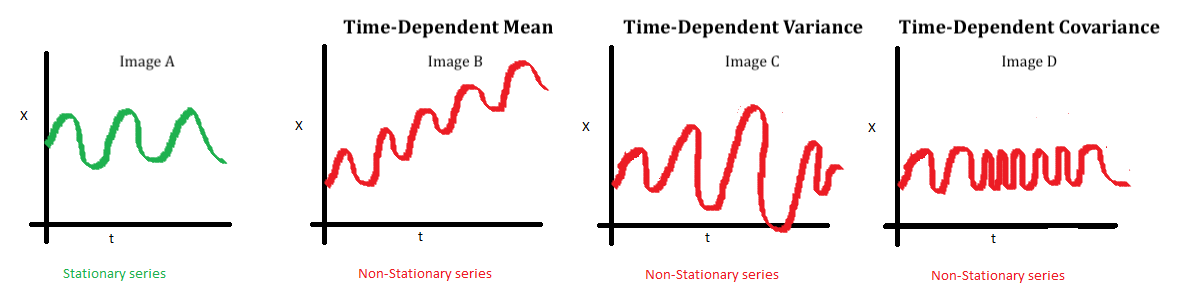

In [5]:
def check_stationarity(series):
    # Thanks to https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

### An important component of time series is the seasonality, it refers to repeating patterns or fluctuations in the data that occur at regular intervals, often within a year. We are going to catch seasonality including all the crucial information about when the sample was taken in a period of a year. 
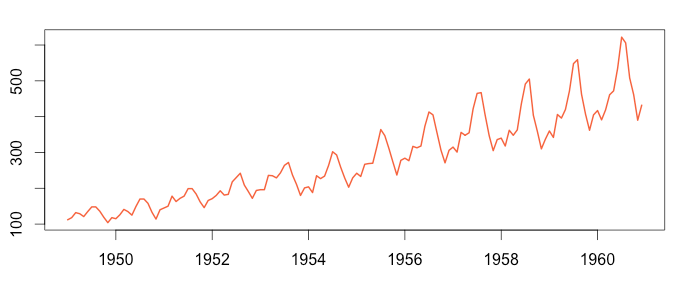

In [6]:
def date_features(df):
    # Create time series features based on time series index.
    df.index = pd.to_datetime(df.index)
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

## Making the stationarity check

In [7]:
check_stationarity(df.Close)

ADF Statistic: 0.655713
p-value: 0.988911
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Non-stationary


In [8]:
check_stationarity(df.Close.diff(periods=1).dropna())

ADF Statistic: -12.806170
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


### We observed the transformation to stationarity after a single differentiation of the actual values. To address the noise introduced by this process, we are introducing a new feature. This addition enables the model to effectively explain the variations caused by the differentiation, enhancing our understanding of the underlying patterns within the data.

In [9]:
df["close_diff_1"] = df.Close.diff(periods=1)

## Adding some date features to explain seasonality.

In [10]:
df.index = df["Date"]
df.drop("Date", axis=1, inplace=True)
df = date_features(df)

## Checking Partial Autocorrelation
#### Partial Autocorrelation is a measure used in time series analysis and statistics to identify the direct relationship between an observation at a specific time point and its lagged values, while controlling for the effect of other lags in between. It helps in understanding the direct influence of past observations on the current observation, eliminating the indirect influences through intermediate time points.
### Example: 
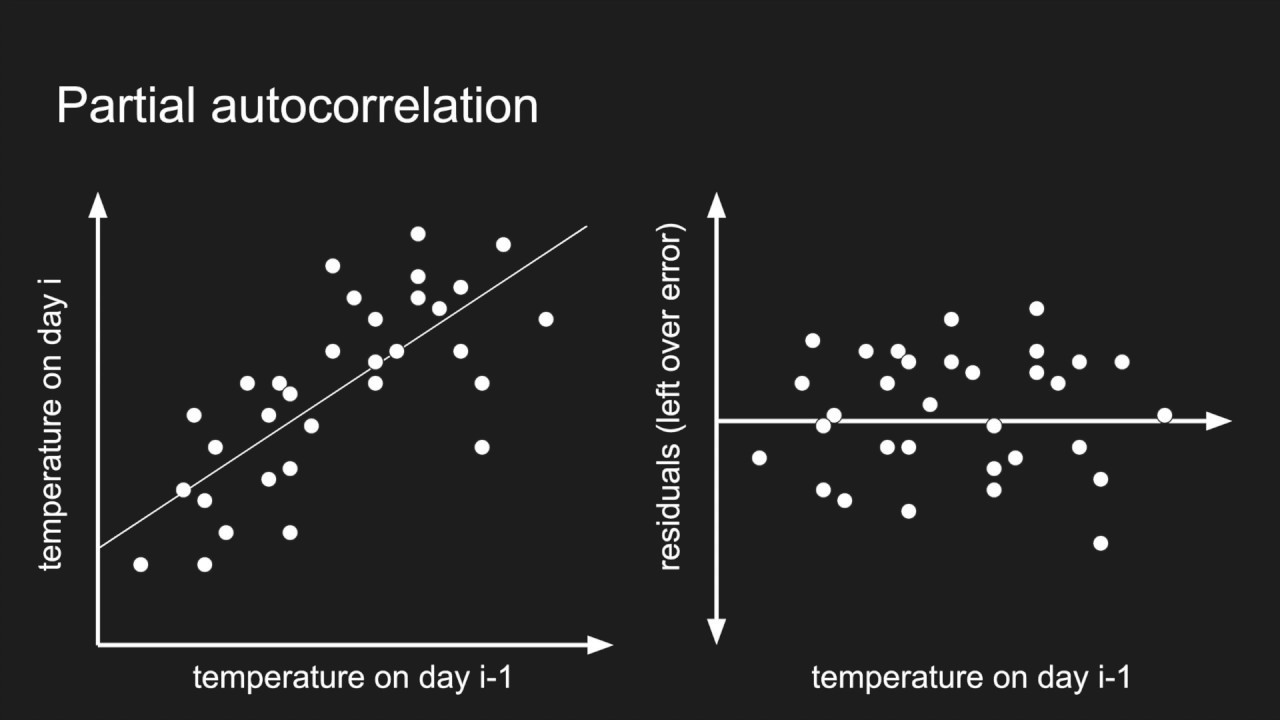

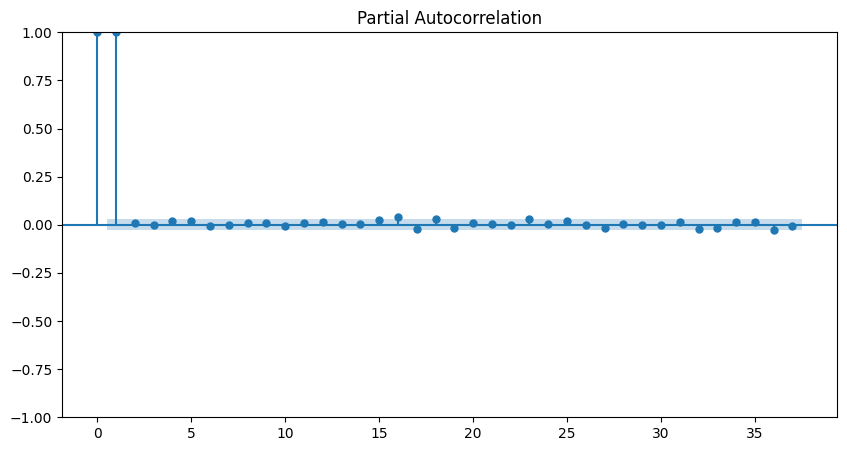

In [11]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['Close'], method='ywm')
plt.show()

### The data exhibits significant autocorrelation at lag 1. Therefore, we will introduce a feature representing the price lagged by 1.

In [12]:
df["close(-1)"] = df['Close'].shift(1)

## Adding the indicators
### The values are empirically chosen, biased by personal experience and some research about the performance of these indicators.

In [13]:
df['SMA'] = SMA(df, 13)
df['EMA'] = EMA(df, 9) 
df['MACD'] = MACD(df, 24, 52)
df['RSI'] = RSI(df, 14)
df['Upper_Band'], df['Lower_Band'] = Bollinger_Bands(df, 10)

## Creating new variables to avoid multicolineality
#### Multicollinearity, also known as Collinearity, is a statistical phenomenon in regression analysis where two or more predictor variables in a multiple regression model are highly correlated. It sometimes increase the difficulty in identifying important variables, increase standard errors and reduce precision. 

In [14]:
df["H_L_diff"] = df["High"] - df["Low"]
df.drop("Adj Close", axis=1, inplace=True)
df.drop("High", axis=1, inplace=True)
df.drop("Low", axis=1, inplace=True)
df["Bands_diff"] = df["Upper_Band"] - df["Lower_Band"]
df.drop("Upper_Band", axis=1, inplace=True)
df.drop("Lower_Band", axis=1, inplace=True)
df["target"] = df["Close"].shift(-1)
df.tail()

,Open,Close,Volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close(-1),SMA,EMA,MACD,RSI,H_L_diff,Bands_diff,target
Date,,,,,,,,,,,,,,,,,,,
2023-05-24,121.120003,120.900002,34182600,-1.659996,2,2,5,2023,144,24,21,122.559998,117.839231,120.103250,5.650808,2.004609,2.050003,11.703237,123.480003
2023-05-25,124.519997,123.480003,42317000,2.580002,3,2,5,2023,145,25,21,120.900002,119.047693,120.778601,5.822042,2.357890,3.360001,10.803181,124.610001
2023-05-26,123.169998,124.610001,35635900,1.129997,4,2,5,2023,146,26,21,123.480003,120.375386,121.544881,6.003815,2.524524,2.810005,10.214644,123.669998
2023-05-30,125.639999,123.669998,35076700,-0.940002,1,2,5,2023,150,30,22,124.610001,121.292309,121.969904,6.106882,2.196615,3.660004,7.001372,122.870003
2023-05-31,122.750000,122.870003,37325800,-0.799995,2,2,5,2023,151,31,22,123.669998,121.776924,122.149924,6.145879,1.962935,1.559998,5.469598,NaN


## Extracting the last day value
#### We are going to extract the last value (assuming it is today's) for demonstration purposes, simulating a prediction for tomorrow's day later.

In [15]:
last_row = df.tail(1)
df.drop(df.tail(1).index, inplace=True)
df.dropna(inplace=True)

## Scaling the values 
#### To maintain the integrity of our data, we employ MinMaxScaler, ensuring values are scaled between 0 and 1 for optimal model training. While MinMaxScaler is our go-to choice, exploring different scalers, such as StandardScaler or logarithmic transformations, based on your data's nuances can enhance the model's comprehension. Choosing the right scaler aligns the data with the model's expectations, refining understanding and boosting accuracy.

In [16]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

### Function to split the data
#### Make sure you are not shuffling the data

In [17]:
def train_test_split(df, test_size=0.2):
    data = df.values
    
    feature_scaler.fit(data[:, :-1]) 
    target_scaler.fit(data[:, -1:]) 
    scaled_data = feature_scaler.transform(data[:, :-1])
    scaled_target = target_scaler.transform(data[:, -1:])
    data_scaled = np.concatenate((scaled_data, scaled_target), axis=1)
    
    
    n = int(len(data_scaled) * (1 - test_size))
    return data_scaled[:n], data_scaled[n:]

### Function to train the data and make the prediction

In [18]:
def xgb_prediction(train, value):
    train = np.array(train)
    X, Y = train[:, :-1], train[:, -1]
    global model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

    model.fit(X, Y)
    val = np.array(value).reshape(1, -1)
    prediction = model.predict(val)
    return prediction[0] 

### Function to make the walk-forward validation 

In [19]:
def walk_forward_validation(data, percentage=0.2):
    # In this case -1 is the target column (last one)
    train, test = train_test_split(data, percentage)
    predictions = []
    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_Y = test[i, :-1], test[i, -1] 
        pred = xgb_prediction(history, test_X) 
        predictions.append(pred)
        history.append(test[i])
    
    Y_test = target_scaler.inverse_transform(test[:, -1:].reshape(1, -1))
    Y_pred = target_scaler.inverse_transform(np.array(predictions).reshape(1, -1))
    test_rmse = mean_squared_error(Y_test, Y_pred, squared=False) # squared=False to get RMSE instead of MSE

    return test_rmse, Y_test, Y_pred

In [20]:
test_rmse, Y_test, predictions = walk_forward_validation(df, 0.2)

## Plotting all results

In [21]:
def plot_values(df, percentage=0.2):

    train, test = train_test_split(df, percentage)
    X, Y = train[:, :-1], train[:, -1]
    train_predictions = model.predict(X)
    
    # unscale the data
    train_predictions = target_scaler.inverse_transform(train_predictions.reshape(-1, 1))
    Y = target_scaler.inverse_transform(Y.reshape(-1, 1))
    train_rmse = mean_squared_error(Y, train_predictions, squared=False)
    
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

    # plot actual vs. predicted values
    # concat Y and Y_test to plot them together
    Y = Y.reshape(-1)
    train_predictions = train_predictions.reshape(-1)
    Y = np.concatenate((Y, Y_test.reshape(-1)), axis=0)
    new_predictions = np.concatenate((train_predictions, predictions.reshape(-1)), axis=0)
    plt.plot(new_predictions, label='Predicted')
    plt.plot(Y, label='Actual')  
    plt.legend()
    plt.show()

Training RMSE: 0.17185161549146064
Testing RMSE: 1.8428242051756223


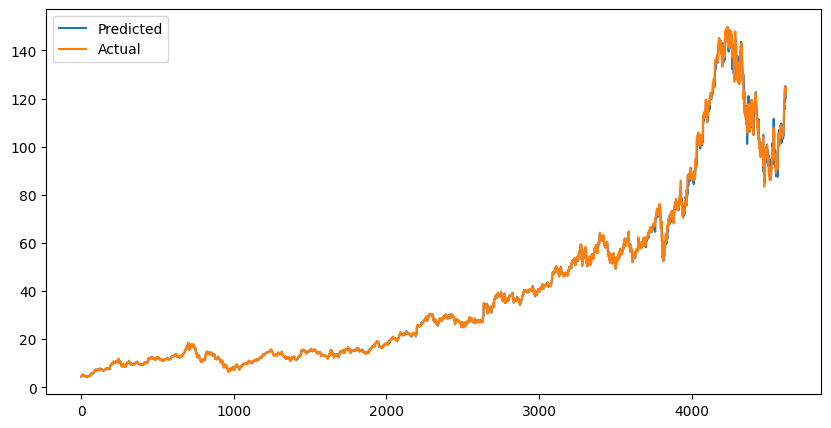

In [22]:
plot_values(df, 0.2)

## Plotting just the test results

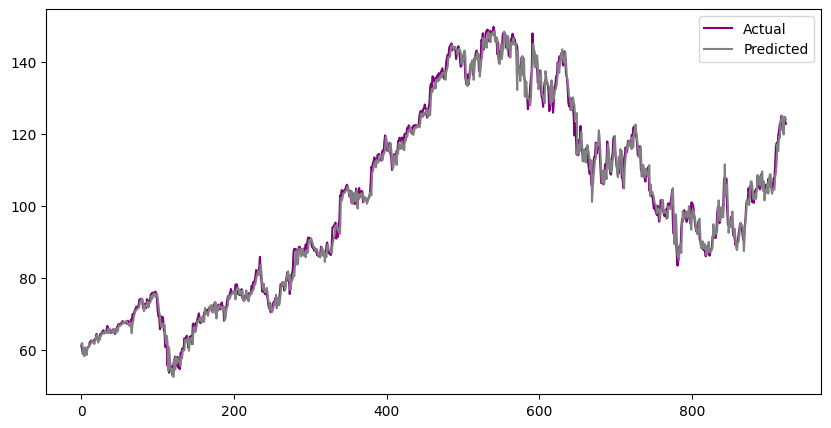

In [23]:
plt.plot(Y_test.reshape(-1), label='Actual', color='purple')
plt.plot(predictions.reshape(-1), label='Predicted', color='gray')
plt.legend()
plt.show()

## Predicting the next day price
#### We are assuming the last row value is the todays price

In [24]:
last_row

,Open,Close,Volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close(-1),SMA,EMA,MACD,RSI,H_L_diff,Bands_diff,target
Date,,,,,,,,,,,,,,,,,,,
2023-05-31,122.75,122.870003,37325800,-0.799995,2,2,5,2023,151,31,22,123.669998,121.776924,122.149924,6.145879,1.962935,1.559998,5.469598,NaN


In [25]:
prediction = xgb_prediction(df.values, last_row.values[0][:-1])
prediction

123.89075

In [26]:
if prediction > last_row["Close"].values: 
    print("Buy")
else:
    print("Sell")

Buy


### Save the model

In [27]:
model.save_model('model.json')

#### Consider this is a notebook focused in the walk-forward validation, there are more important things you can do, like hyperparameter optimization, using more instrumental variables with an statistical approach, extracting more data from different resources as mentioned above. As a trader, I do not recommend that you make decisions based solely on a model's prediction, always use as many resources and analysis as possible.